In [1]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("dark")

In [3]:
class AntColony_TSP:
    def __init__(self, n_points, dist_matrix=None, n_ants=20, max_iter=100, alpha=1, beta=2, evaporation_rate=0.1):
        self.n_points = n_points
        self.dist_matrix = dist_matrix       
        self.n_ants = n_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate        
        self.pheromones = np.full((n_points, n_points), 1e-4)
        
    def initialization(self, n_points):
        points = np.random.rand(n_points, 2)
        self.dist_matrix = spatial.distance.cdist(points, points, metric='euclidean')
        
    def generate_path(self):
        path = []
        visited_cities = set()
        current_city = np.random.randint(len(self.dist_matrix))
        visited_cities.add(current_city)
        path.append(current_city)
        while len(visited_cities) < len(self.dist_matrix):
            unvisited = list(set(range(len(self.dist_matrix))) - visited_cities)
            probabilities = self.calculate_probabilities(current_city, unvisited)
            next_city = np.random.choice(unvisited, p=probabilities)
            visited_cities.add(next_city)
            path.append(next_city)
            current_city = next_city
        return path
    
    def calculate_probabilities(self, current_city, unvisited):
        # p_ij = (τ_ij^α * η_ij^β) / Σ(τ_ij^α * η_ij^β)
        # где p_ij - вероятность перехода муравья из города i в город j, 
        # τ_ij - феромон на ребре (дороге) между городами i и j, 
        # η_ij - эвристическое значение, которое определяется как 1 / d_ij, где d_ij - расстояние между городами i и j, 
        # α и β - параметры, которые определяют влияние феромона и эвристики соответственно.
        
        pheromone = np.power(self.pheromones[current_city, unvisited], self.alpha)
        distance = np.power(1 / self.dist_matrix[current_city, unvisited], self.beta)
        probabilities = pheromone * distance
        probabilities /= np.sum(probabilities)
        return probabilities
    
    def calculate_distance(self, path):
        distance = 0
        for i in range(1, len(path)):
            distance += self.dist_matrix[path[i - 1], path[i]]
        distance += self.dist_matrix[path[-1], path[0]]
        return distance
    
    def pheromones_spread(self, all_paths, all_distances):
        coef_dist = np.zeros(self.pheromones.shape)
        for path, distance in zip(all_paths, all_distances):
            for i in range(1, len(path)):
                coef_dist[path[i - 1], path[i]] += 1/distance
        self.pheromones = (1 - self.evaporation_rate) * self.pheromones + coef_dist

    def run(self):
        self.initialization(self.n_points)
        best_path = None
        best_distance = float('inf')
        for i in range(self.max_iter):
            all_paths = []
            all_distances = []
            for j in range(self.n_ants):
                path = self.generate_path()
                distance = self.calculate_distance(path)
                all_paths.append(path)
                all_distances.append(distance)
                if distance < best_distance:
                    best_distance = distance
                    best_path = path
            self.pheromones_spread(all_paths,all_distances)
        best_path.append(best_path[0])
        return best_path, best_distance

    

In [6]:
aco = AntColony_TSP(n_points=5)
best_path, best_distance = aco.run()
print(best_path)
print(best_distance)

[3, 1, 0, 4, 2, 3]
2.3848445686742052


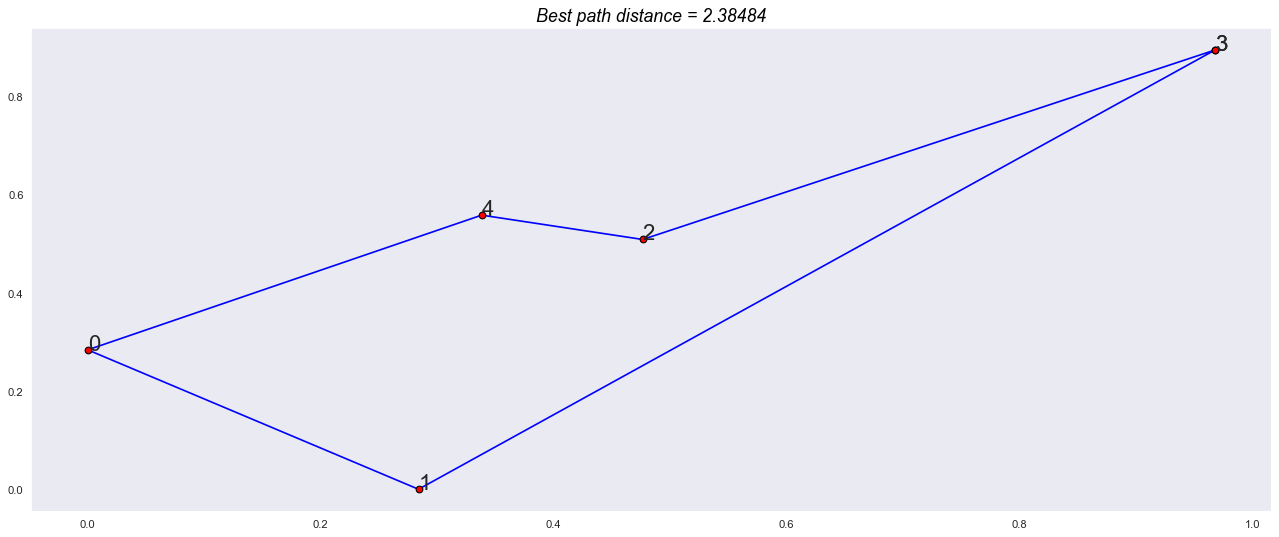

In [7]:
fig, ax = plt.subplots(figsize=(20, 8), dpi=80)

plt.title(f'Best path distance = {np.round(best_distance, 5)}', color='black', fontsize=16, fontstyle='italic')
path_coordinate = aco.dist_matrix[best_path, :]
for index in range(0, len(best_path)):
    ax.annotate(best_path[index], (path_coordinate[index, 0], path_coordinate[index, 1]), fontsize=20)
ax.plot(path_coordinate[:, 0], path_coordinate[:, 1], 'o-', color='b', markerfacecolor='r', markeredgecolor='k')
plt.show()